## Implementation of an object detector 
In this notebook, you will need to implement an CNN based object detector to detect specific objects in given images.

You will find the resources in folder 'src'. It contains the image set for training and testing, the groundtruth of the images, and a folder to place your parameters (weights).

<img src="pics/0__1_.jpg" alt="Biker" />

This task is divided into three sections. This notebook contains only the first section. 

- In the first section, you will train a pre-defined neural network and save the trained parameters to a file. 


In [1]:
from __future__ import absolute_import, division, print_function

import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)
print(tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image, ImageDraw

1.13.1
2.2.4-tf


Check the devices available on your machine:

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12140058699157208720
]


Before we do anything, we need to import the image data.

In [3]:
'''
Load groundtruch
'''
import json
with open('src/groundtruth.txt', 'r') as file:
    lines = json.load(file)

print('There are %d image-label pair in the entire set' %(len(lines)))
print('First entry looks like this:')
print(lines[0])

There are 996 image-label pair in the entire set
First entry looks like this:
['src/images/932.jpg', [0.48984375, 0.5055555555555555, 0.0328125, 0.08333333333333333]]


Now, we need to pick ramdomly from the data set to put aside a subset of images for testing. The model **should not** see this subset of images while training.

In [4]:
'''
This function converts the image into the input type.
'''
def load_input(path):
    img = Image.open(path)
    img = img.resize((320,160))
    input_img = np.asarray(img).astype(np.float32)
    input_img = (input_img/255 - 0.5)/0.25
    return input_img[np.newaxis,:]

'''
This function draws the rectangle around the object
'''
def show_image(image, box):
    img = Image.open(image)
    
    box_top_left = (int((box[0] - box[2]/2)*640), int((box[1] + box[3]/2)*360))
    box_bot_right = (int((box[0] + box[2]/2)*640), int((box[1] - box[3]/2)*360))

    draw = ImageDraw.ImageDraw(img)
    draw.rectangle((box_top_left, box_bot_right), outline = (255,0,0))

    plt.figure(1, figsize = (16, 9), dpi =300)
    plt.imshow(img)
    plt.show()

There are 96 image-label pair in the testing set
There are 900 image-label pair in the training set
First image in the testing set is: src/images/196.jpg
Corresponding box is: [0.5046875, 0.5263888888888889, 0.05625, 0.21388888888888888]
First image in the training set is: src/images/259.jpg
Corresponding box is: [0.49921875, 0.5333333333333333, 0.0390625, 0.14444444444444443]


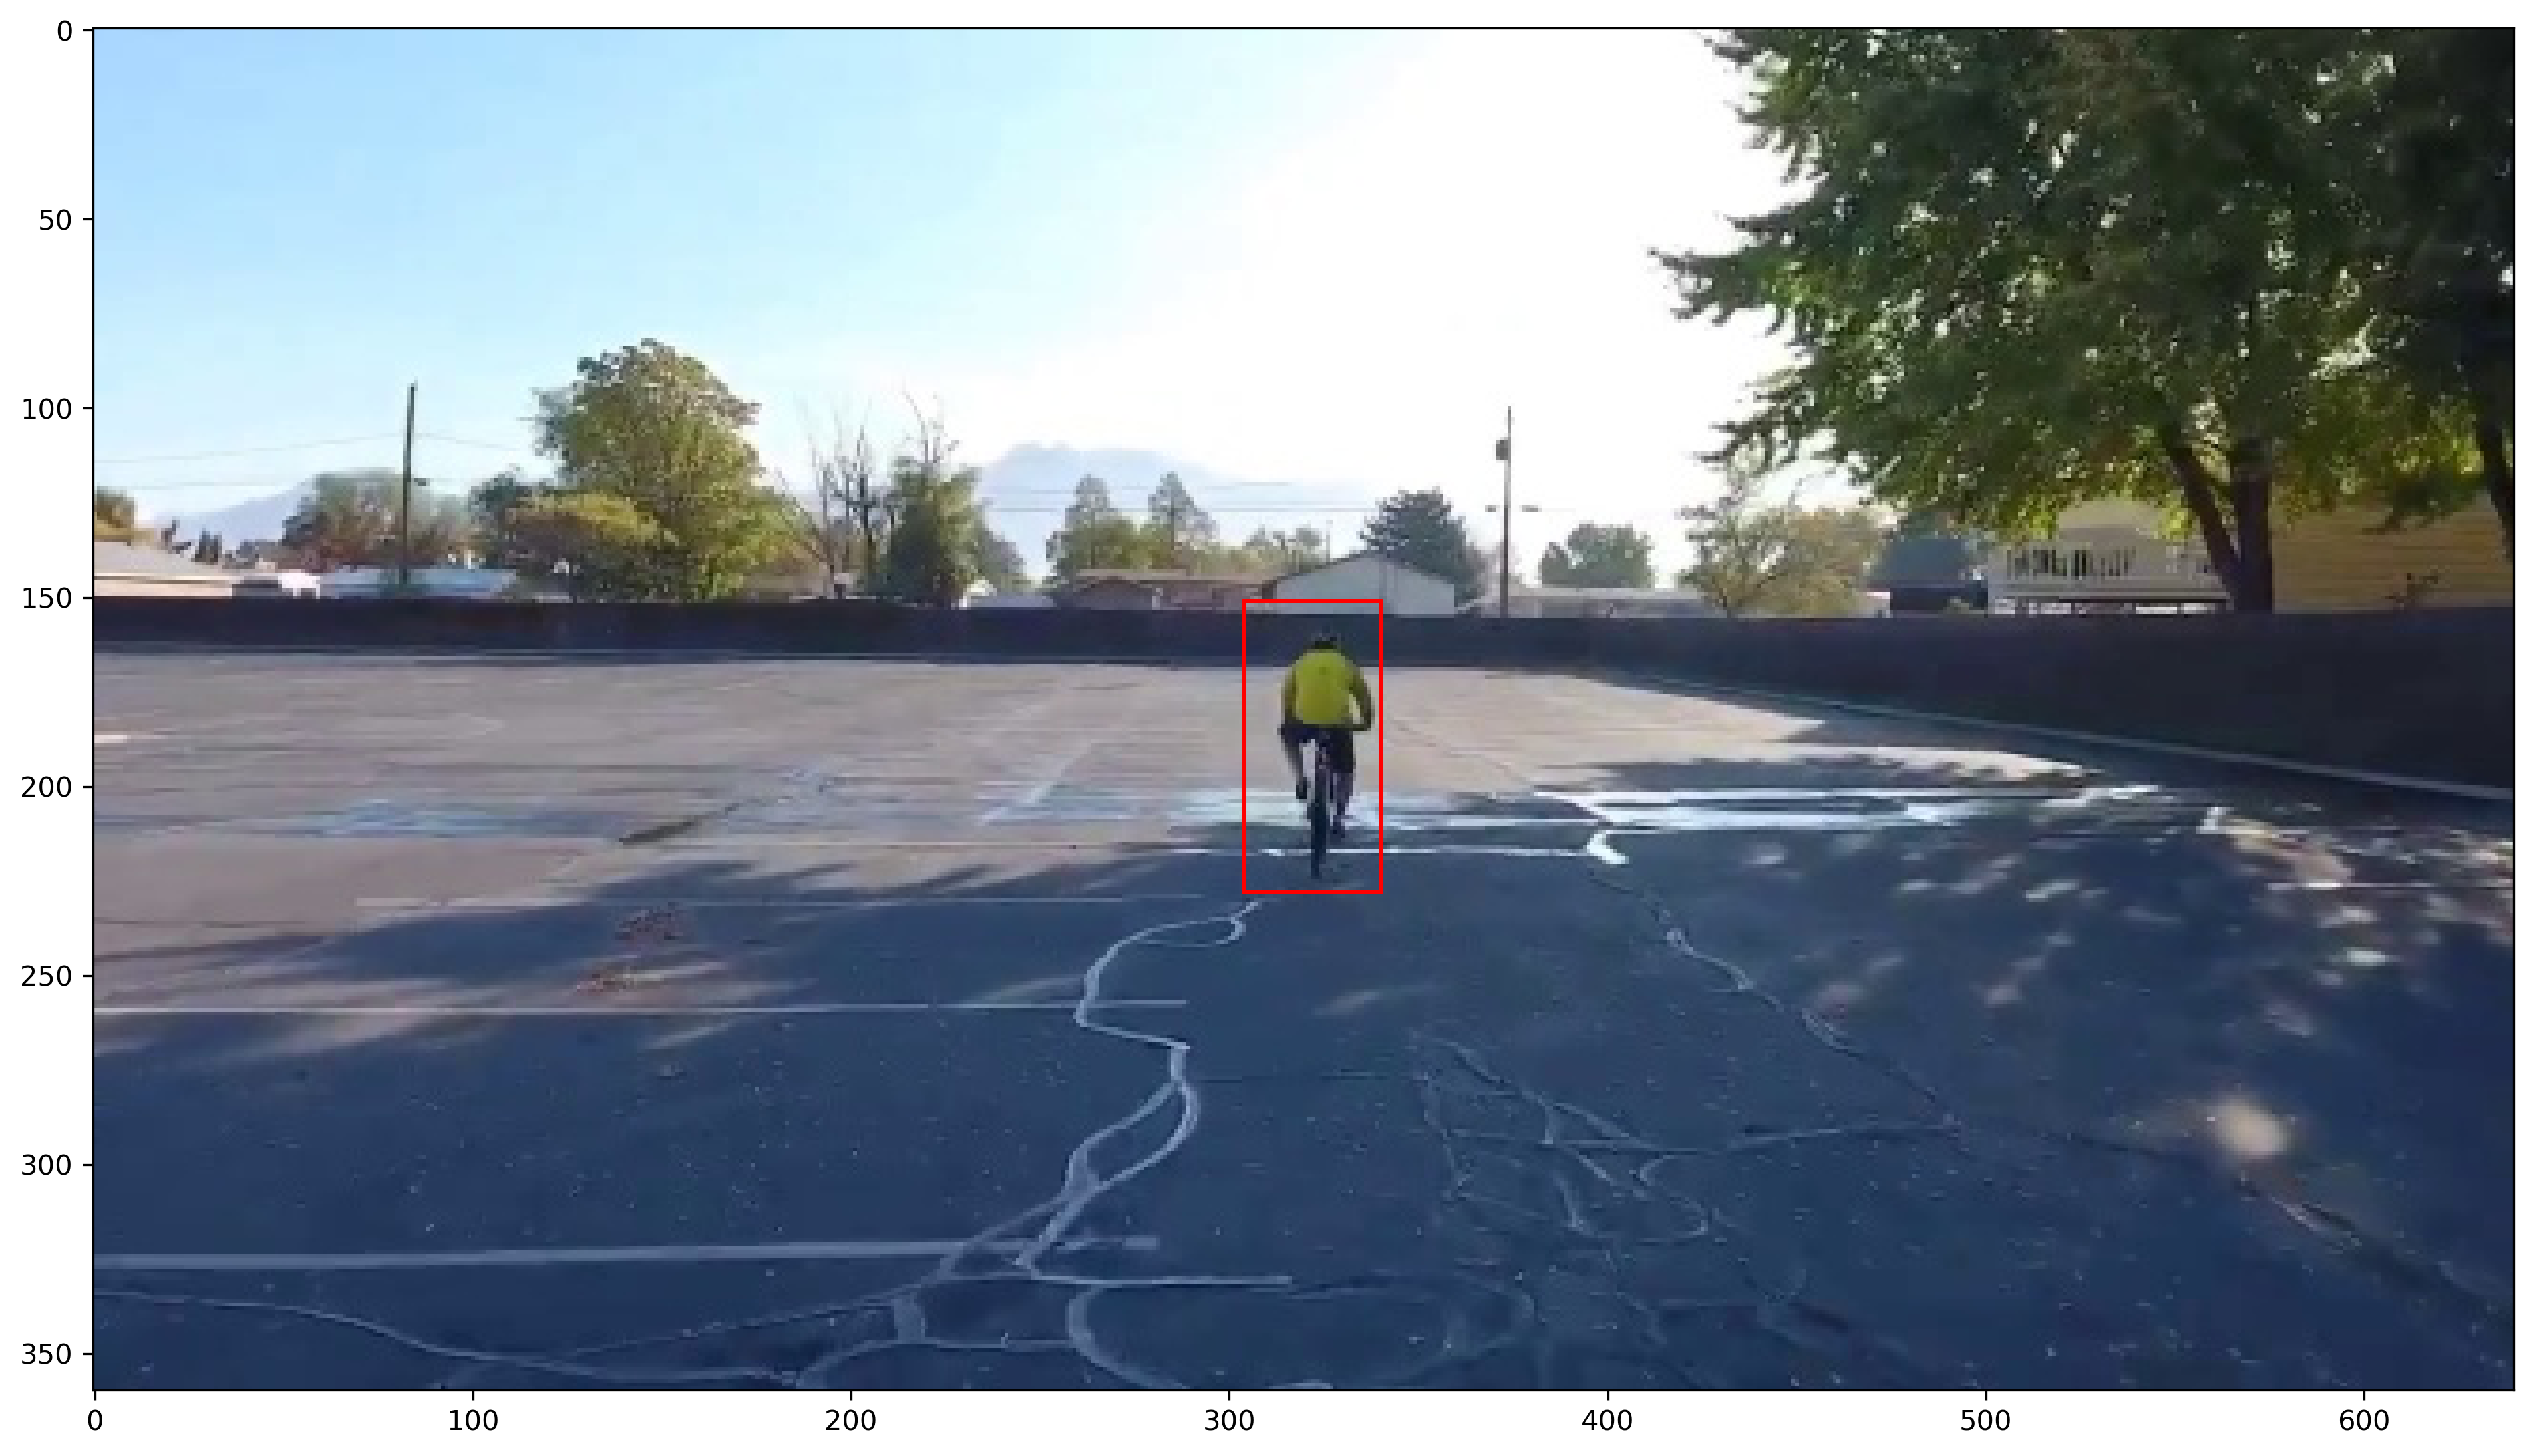

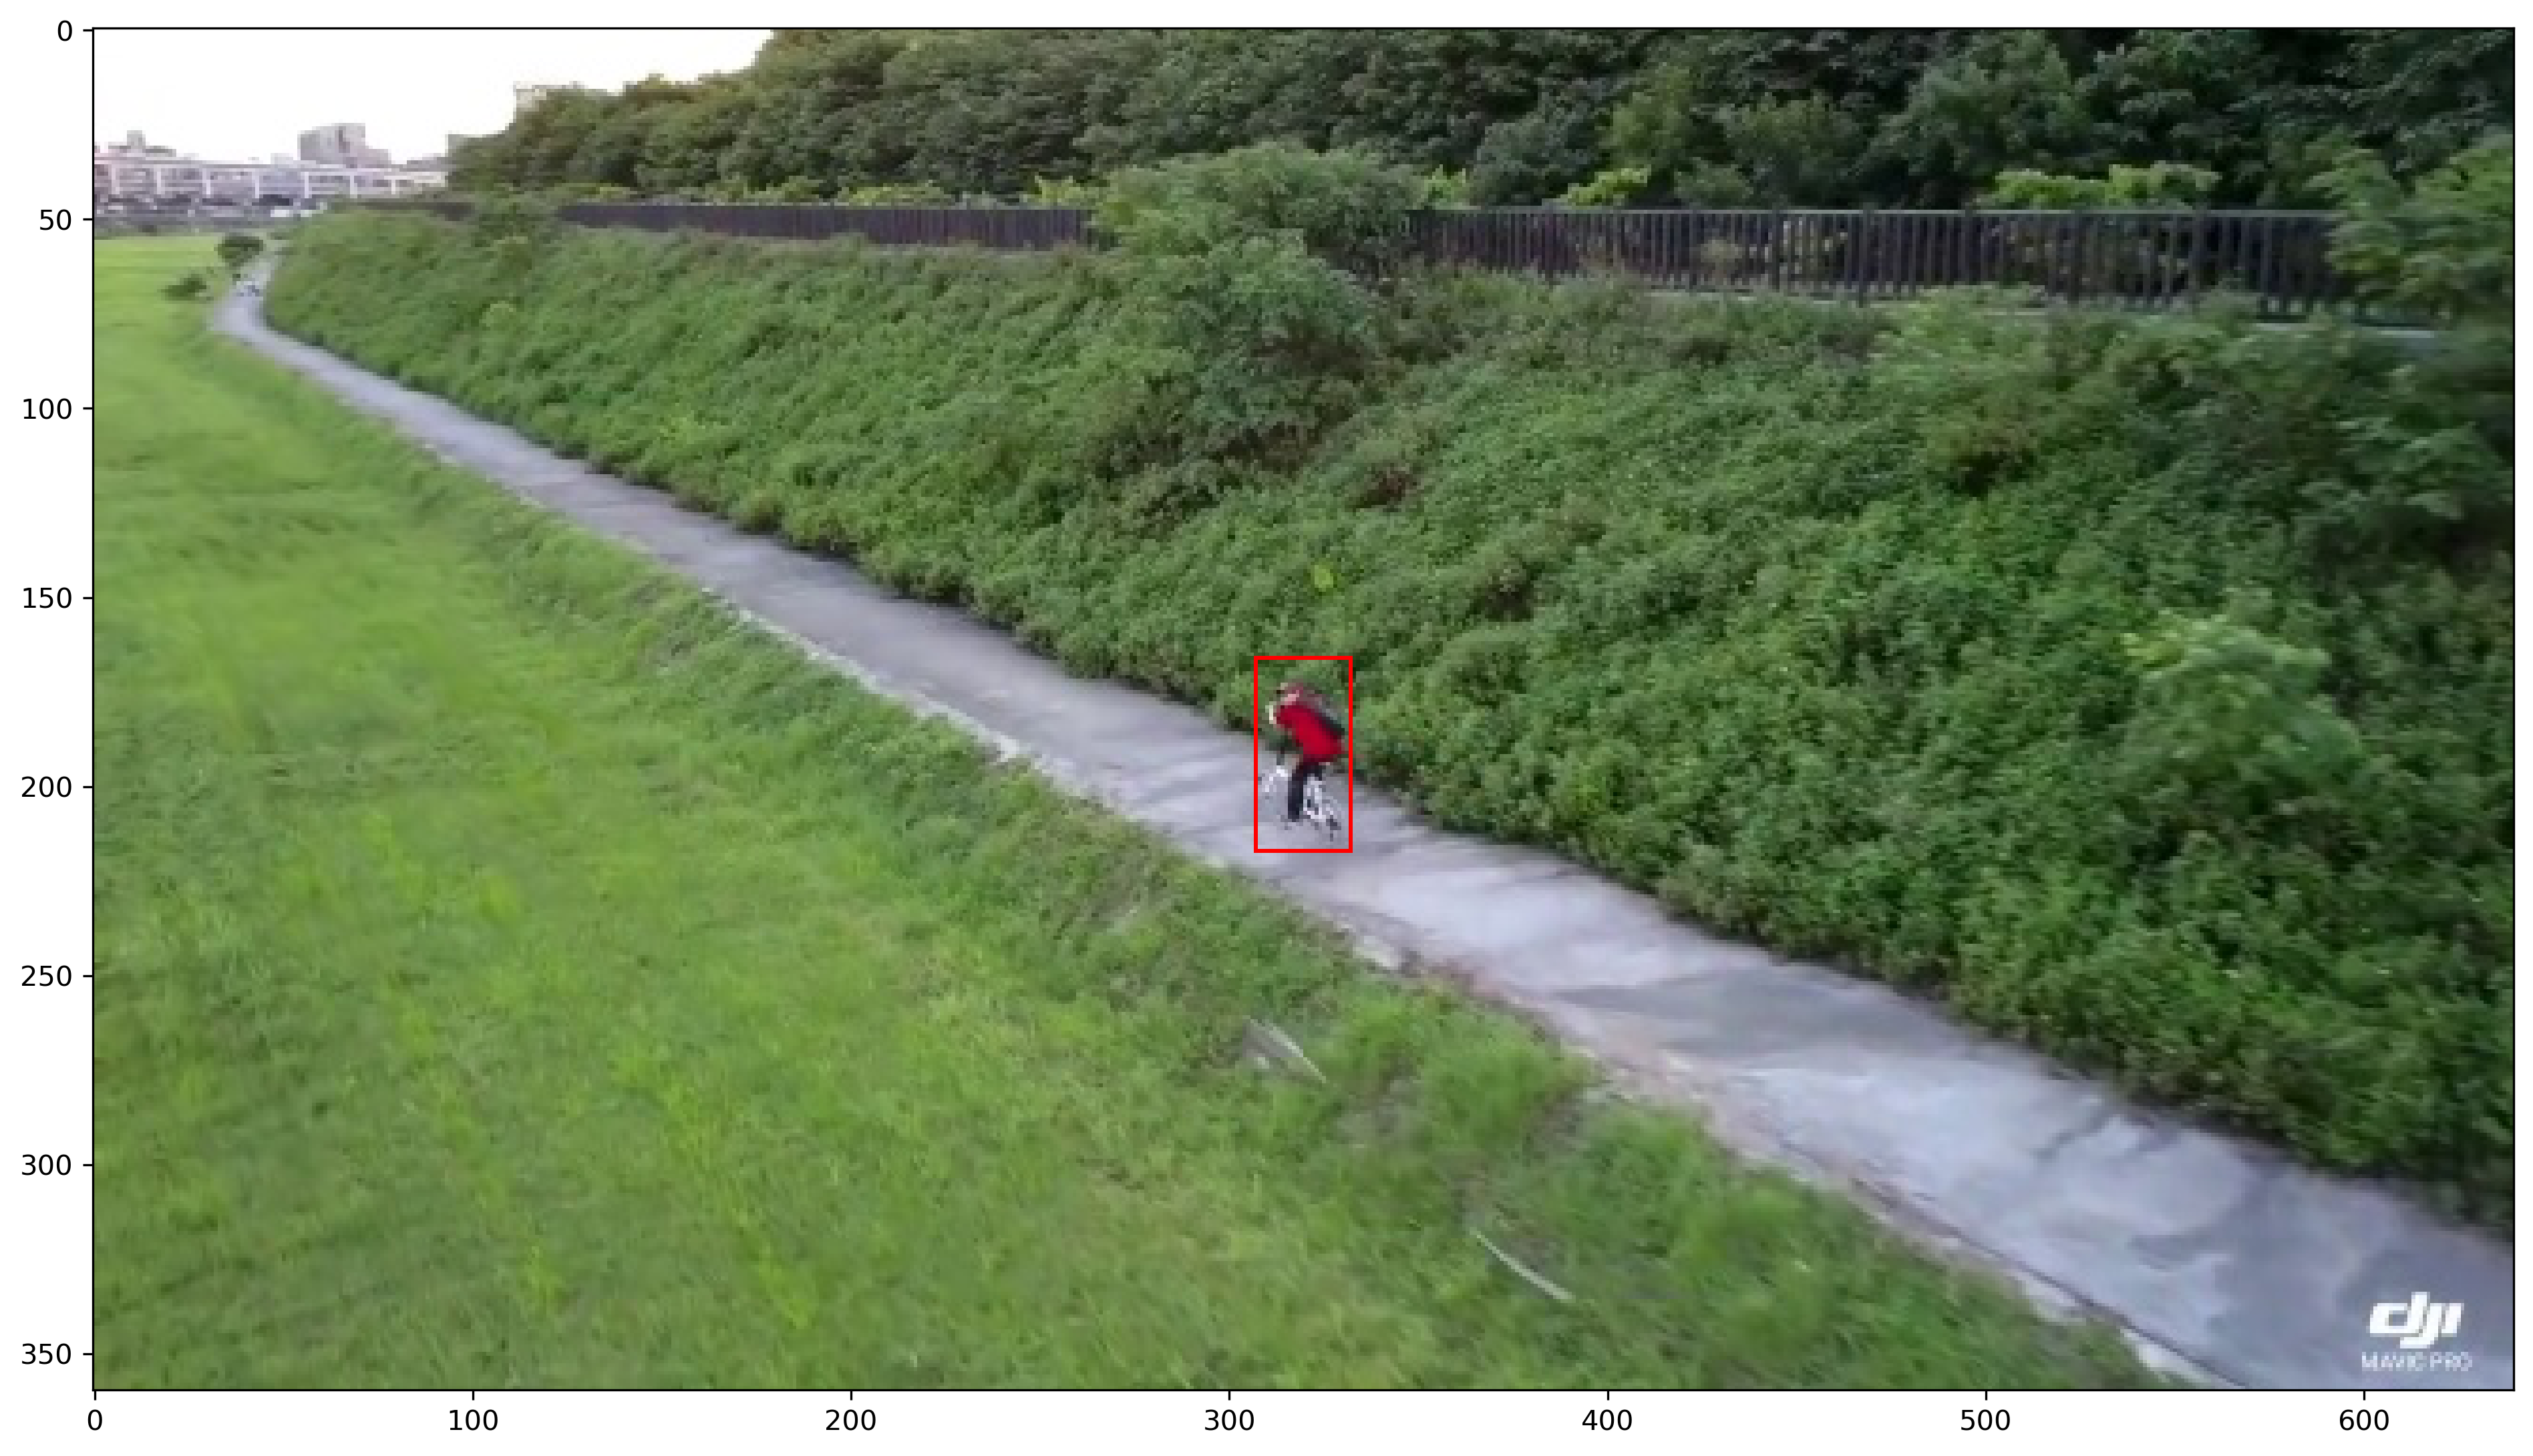

In [10]:
'''
Let's put aside 96 images for testing and 900 for training
'''
import random
random.shuffle(lines)

test_lines = lines[:96]
print('There are %d image-label pair in the testing set' %(len(test_lines)))
train_lines = lines[96:]
print('There are %d image-label pair in the training set' %(len(train_lines)))

test_images_paths = [line[0] for line in test_lines]
test_labels = [line[1] for line in test_lines]
train_images_paths = [line[0] for line in train_lines]
train_labels = [line[1] for line in train_lines]
print('First image in the testing set is: %s' %(test_images_paths[0]))
print('Corresponding box is: %s' %(test_labels[0]))

print('First image in the training set is: %s' %(train_images_paths[0]))
print('Corresponding box is: %s' %(train_labels[0]))

show_image(test_images_paths[0], test_labels[0])
show_image(train_images_paths[0], train_labels[0])

In [ ]:
'''
Now import those images
'''

test_images = []
for image_path in test_images_paths:
    image = load_input(image_path)
    test_images.append(image)
test_images = np.array(test_images).reshape((96, 160, 320, 3))
test_labels = np.array(test_labels)
print(test_labels)
print(np.shape(test_images))
print(np.shape(test_labels))
    
train_images = []
for image_path in train_images_paths:
    image = load_input(image_path)
    train_images.append(image)
train_images = np.array(train_images).reshape((900, 160, 320, 3))
train_labels = np.array(train_labels)
print(train_labels)
print(np.shape(train_images))
print(np.shape(train_labels))

## section 1
First, a pre-defined keras model is given. Your task is to play with the training configurations and explore their effects on the training performance (speed, accuracy, etc.)

In [ ]:
model = tf.keras.models.Sequential([
    #first dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1,1), input_shape=(160, 320, 3)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(48, (1, 1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #maxpooling
    layers.MaxPool2D(strides=(2, 2)),
    
    #second dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1,1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(96, (1, 1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #maxpooling
    layers.MaxPool2D(strides=(2, 2)),
    
    #third dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1,1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(192, (1,1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #maxpooling
    layers.MaxPool2D(strides =(2,2)),
    
    #fourth dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(384, (1,1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #fifth dw-pw module
    layers.DepthwiseConv2D((3, 3),padding='same', depth_multiplier=1, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(512, (1, 1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #output
    layers.Conv2D(10,(1,1), padding='same', strides=(1, 1)),
    ]
)

Save the model to a checkpoint file. I choose not to use ```keras.save()``` because I think checkpoint give you more control when you deploy it. 

In [ ]:
checkpoint_path = "keras_saves/cp_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=0),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0)
]

time_s = time.perf_counter()
model.summary()
# adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_images, 
    train_labels,
    epochs = 50,
    validation_split = 0.2,
    shuffle = True,
    callbacks = cp_callback)

test_loss, test_acc = model.evaluate(test_images, test_labels)
time_t = time.perf_counter()

mins = int((time_t - time_s)/60)
secs = time_t - time_s - mins*60

print('Test accuracy:', test_acc)
print('Total Elapsed Time: %d mins %.2f secs' %(mins, secs))
predictions = model.predict(test_images)